In [339]:
import sys
sys.path.append('../lib')
import numpy as np
import matplotlib.pyplot as plt
from Powerspectra import powerspectrum
from clean_trajectories import iterative_filtering_and_fitting, process_data, clean_trajectory, linear_fit
from MBR_calculation import mean_back_realxation, b_distribution
from scipy.optimize import minimize


In [404]:
def Laplace_NLL(params, x_data, y_data, function):
    y_model = function(x_data, *params)
    NLL = np.sum(y_data / y_model + np.log(y_model))
    return NLL


def fit_function(x, a, b, c):
    return a*x**b + c

def initial_guess(x_data, y_data):
    log_x_data = np.log(x_data)
    log_y_data = np.log(y_data)
    c = np.exp(log_y_data[-1])
    index_zero = np.argmin(np.abs(log_x_data))
    a = np.exp(log_y_data[index_zero]) - c
    b = (log_y_data[0] - log_y_data[index_zero] )/log_x_data[0]
    return np.array([a, b, c])

def fit_result(x_data, y_data, fit_function = fit_function, initial_guess = initial_guess):
    p_0 = initial_guess(x_data, y_data)
    result = minimize(Laplace_NLL, p_0, args=(x_data, y_data, fit_function), method='Nelder-Mead')
    return result

def get_suprise(x_data, y_data, fit_function = fit_function, initial_guess = initial_guess):
    result = fit_result(x_data, y_data, fit_function = fit_function, initial_guess = initial_guess)

    suprise = []
    for i in range(len(x_data)):
        NLL=Laplace_NLL(result.x, [x_data[i]], [y_data[i]], fit_function)
        expected_NLL = 1+np.log(fit_function(x_data[i], *result.x))
        suprise.append(NLL-expected_NLL)
    suprise = np.array(suprise)
    return suprise
def find_max_cumsum_interval(cumsum):
    """
    Find the indices i and j (where j > i) such that cumsum[j] - cumsum[i] is maximal.

    Args:
    cumsum (np.array): The cumulative sum array.

    Returns:
    tuple: A tuple (i, j) representing the indices.
    """
    argmin_cumsum = np.argmin(cumsum)
    argmax_cumsum = np.argmax(cumsum)

    if argmax_cumsum < argmin_cumsum:
        min_before_max = np.argmin(cumsum[:argmax_cumsum])
        max_before_min = np.argmax(cumsum[argmin_cumsum:])

        first_diff = cumsum[argmax_cumsum] - cumsum[min_before_max]
        second_diff = cumsum[max_before_min + argmin_cumsum] - cumsum[argmin_cumsum]

        if first_diff > second_diff:
            return (min_before_max, argmax_cumsum)
        else:
            return (argmin_cumsum, max_before_min + argmin_cumsum)
    else:
        return (argmin_cumsum, argmax_cumsum)


def delete_peak(x_data,y_data,fit_function = fit_function, initial_guess = initial_guess):
    suprise = get_suprise(x_data, y_data, fit_function, initial_guess)

    cumsum_sup = np.cumsum(suprise)
    (start_peak, end_peak) = find_max_cumsum_interval(cumsum_sup)

    exclude_indices = np.array(range(start_peak,end_peak))
    filtered_x_data = np.delete(x_data, exclude_indices)
    filtered_y_data = np.delete(y_data, exclude_indices)

    return filtered_x_data, filtered_y_data


In [405]:
example_data_path = r'\\134.76.13.158\betzlab\Julian\Hydrogel\measurement_2\10_khz\corr\x_trajecories.npy'
example_data = np.load(example_data_path)
f = 1/1000
fk, ps = powerspectrum(example_data, f)

In [406]:
result = fit_result(fk, ps, fit_function = fractional_KV, initial_guess = lambda x,y: [1,1,0.1,0.9,0,0])
#result = fit_result(fk, ps)
suprise = get_suprise(fk, ps)

C:\Users\jschulz\AppData\Local\Temp\ipykernel_14668\2760822330.py:3: RuntimeWarning: invalid value encountered in log
  NLL = np.sum(y_data / y_model + np.log(y_model))


In [410]:
from sympy import symbols, Eq, sin, cos, pi, solve

# Define the variables
x, y = symbols('x y')

# Define the equation sin(pi/2*x) = 2*sin(pi/2*y)*cos(pi/2*(y-x))
equation = Eq(sin(pi/2*x), 2*sin(pi/2*y)*cos(pi/2*(y-x)))

# Solve the equation step by step
solution = solve(equation, x)
solution


[2,
 -2*I*log(-exp(I*pi*y/2))/pi,
 -2*I*log(-exp(I*pi*y))/pi,
 -2*I*log(exp(I*pi*y))/pi]

: 

In [407]:
output = fractional_KV(fk, *result.x)
np.max(output)

635.1964799943634

In [408]:
result.x

array([-5.36239199e-03,  1.61570782e+00,  3.16002446e-02,  1.73020751e+00,
        1.19645351e-04,  4.68410688e-07])

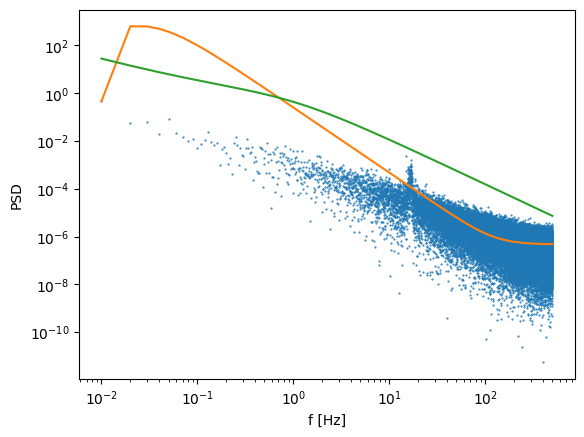

In [409]:
#plot initial guess
plt.plot(fk, ps, 'o', markersize=0.5)
plt.plot(fk, fractional_KV(fk, *result.x))
plt.plot(fk, fractional_KV(fk, *[1,1,0.1,0.9,0,0]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.show()


In [357]:
def fractional_KV(omega,A, B, alpha, beta, m, noise):
    # Using numpy for vectorized computations

    # Precompute common terms to avoid redundant calculations
    omega_alpha = omega ** alpha
    omega_beta = omega ** beta

    # Calculation of the numerator
    numerator = A * omega_alpha / omega * np.sin(np.pi * alpha / 2) + B * omega_beta / omega * np.sin(np.pi * beta / 2)
    
    # Calculation of the denominator
    denominator = (A**2 * omega_alpha**2 + 
                   B**2 * omega_beta**2 +
                   2 * A * B * omega_alpha * omega_beta * np.cos(np.pi / 2 * (alpha - beta)) +
                   m**2 * omega**4 -
                   2 * m * (A * omega_alpha * omega * np.cos(np.pi / 2 * alpha) + 
                            B * omega_beta * omega * np.cos(np.pi / 2 * beta)))
    
    # Final calculation
    result = np.divide(numerator, denominator, out=np.full_like(denominator, np.inf), where=denominator!=0) + noise
    return result

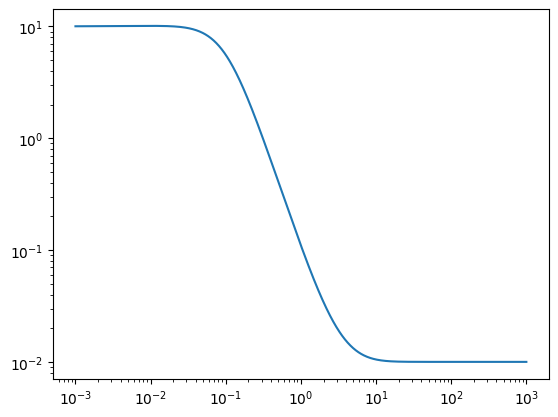

In [358]:
frequencies = np.logspace(-3, 3, 1000)
plt.loglog(frequencies, fractional_KV(frequencies,1, 10, 0, 1, 1, 0.01))

Text(0, 0.5, 'suprise')

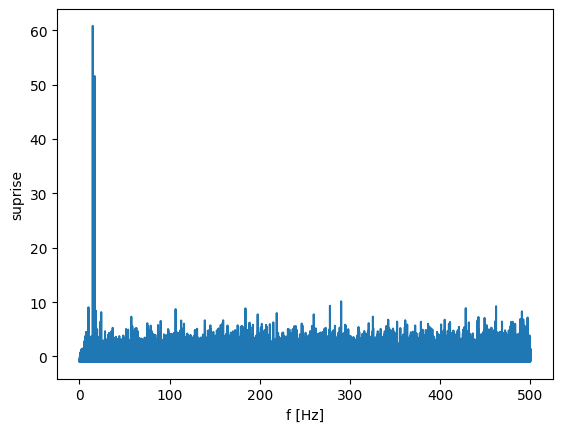

In [171]:
#plot suprise
plt.plot(fk, suprise)
plt.xlabel('f [Hz]')
plt.ylabel('suprise')

Text(0, 0.5, 'Cumalative Sum of surprise')

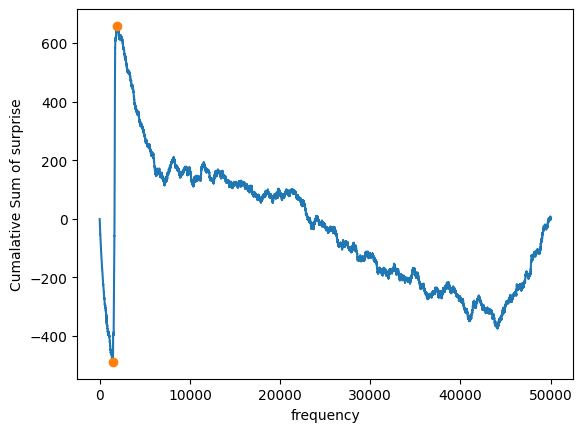

In [172]:
cumsum_sup = np.cumsum(suprise)
(start_peak, end_peak) = find_max_cumsum_interval(cumsum_sup)
plt.plot(cumsum_sup)
plt.plot([start_peak, end_peak], [cumsum_sup[start_peak], cumsum_sup[end_peak]], 'o')
plt.xlabel('frequency')
plt.ylabel('Cumalative Sum of surprise')

In [372]:
from scipy.special import erf, erfinv
def significance(N, E):
    return 0.5 * (1 - erf(1/np.sqrt(N) * erfinv(1-2 * np.exp(-(E/2 + 1)))))

def inverse_significance(N, p):
    return - (1 + np.log(1 - erf(np.sqrt(N) * erfinv(1 - 2 * p))))

In [373]:
E = np.max(cumsum_sup)
N = len(fk)
p = 0.05    # significance level
print(significance(N, E))
print(inverse_significance(N, p))


0.0
inf


C:\Users\jschulz\AppData\Local\Temp\ipykernel_14668\175531477.py:6: RuntimeWarning: divide by zero encountered in log
  return - (1 + np.log(1 - erf(np.sqrt(N) * erfinv(1 - 2 * p))))


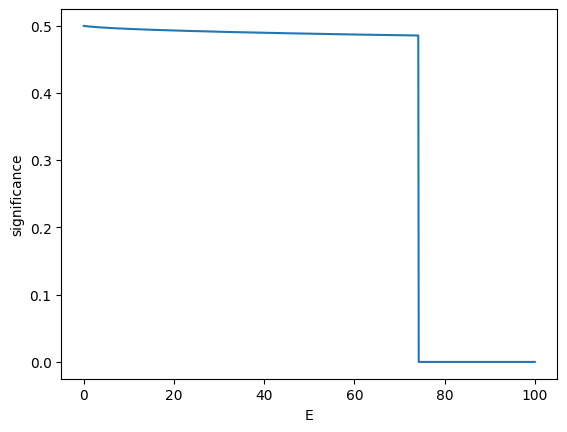

In [374]:
E_values = np.linspace(0, 100, 1000)
significance_values = significance(N, E_values)
plt.plot(E_values, significance_values)
plt.xlabel('E')
plt.ylabel('significance')
plt.show()


In [224]:
erfinv(.9999999999999999)

5.8635847487551676

In [211]:
np.sqrt(N)

223.60679774997897

In [215]:
erf(10)

1.0

In [198]:
2 * np.exp(-(E + 1))

7.761958184497726e-287

In [199]:
significance(len(cumsum_sup),np.max(cumsum_sup))

0.0

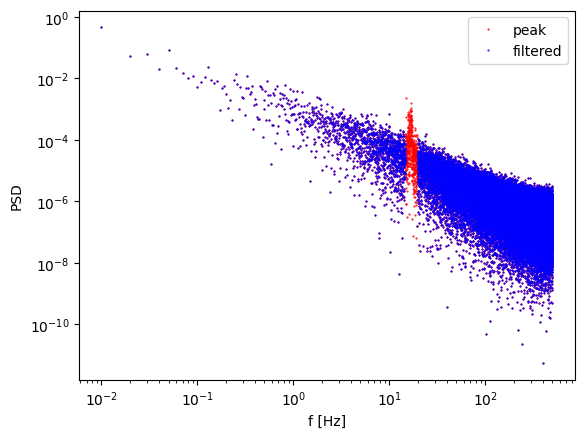

In [379]:
filtered_fk, filtered_ps = delete_peak(fk, ps)


plt.plot(fk, ps, 'o', markersize=0.5, color='red', label='peak')
plt.plot(filtered_fk, filtered_ps, 'o', markersize=0.5, color='blue', label='filtered')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.show()

In [394]:
result = fit_result(filtered_fk, filtered_ps, fit_function = fractional_KV, initial_guess = lambda x,y: [1,0.5,0.1,0.9,0,0])

C:\Users\jschulz\AppData\Local\Temp\ipykernel_14668\2760822330.py:3: RuntimeWarning: invalid value encountered in log
  NLL = np.sum(y_data / y_model + np.log(y_model))


In [396]:
result.x

array([ 9.72336201e+02, -5.08268473e+02,  4.78808488e-01,  4.78309882e-01,
       -1.02963443e-01,  3.62633461e-07])

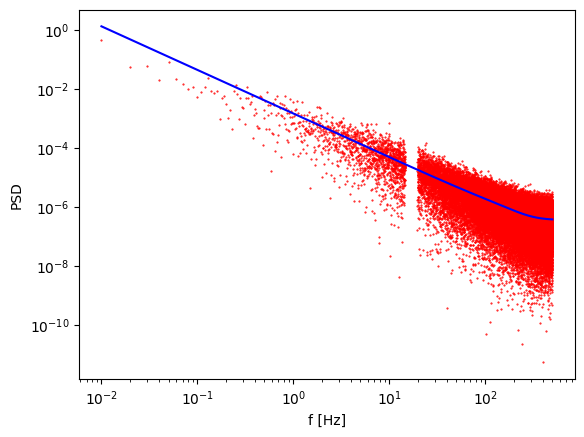

In [397]:
plt.plot(filtered_fk, filtered_ps, 'o', markersize=0.5, color='red', label='peak')
plt.plot(filtered_fk, fractional_KV(filtered_fk, *result.x), color='blue', label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.show()

In [151]:

result = fit_result(filtered_fk, filtered_ps)
suprise = get_suprise(filtered_fk, filtered_ps)


C:\Users\jschulz\AppData\Local\Temp\ipykernel_14668\4277941835.py:3: RuntimeWarning: invalid value encountered in log
  NLL = np.sum(y_data / y_model + np.log(y_model))


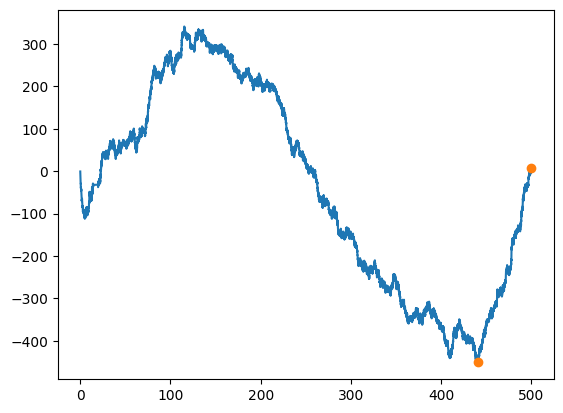

In [152]:
cumsum_sup = np.cumsum(suprise)
(start_peak, end_peak) = find_max_cumsum_interval(cumsum_sup)
plt.plot(filtered_fk, cumsum_sup)
plt.plot([filtered_fk[start_peak], filtered_fk[end_peak]], [cumsum_sup[start_peak], cumsum_sup[end_peak]], 'o')

In [165]:
num_filters = 5
data = [(fk,ps)]
for i in range(num_filters):
    last_data = data[-1]
    filtered_fk, filtered_ps = delete_peak(last_data[0], last_data[1])
    data.append((filtered_fk, filtered_ps))

C:\Users\jschulz\AppData\Local\Temp\ipykernel_14668\4277941835.py:3: RuntimeWarning: invalid value encountered in log
  NLL = np.sum(y_data / y_model + np.log(y_model))


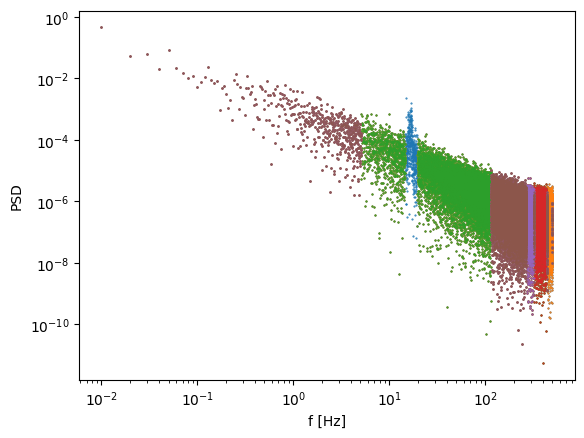

In [166]:
for i in range(num_filters+1):
    plt.plot(data[i][0], data[i][1], 'o', markersize=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('PSD')
plt.show()

In [159]:
x_data = data[-1][0]
y_data = data[-1][1]
suprise = get_suprise(x_data, y_data, fit_function, initial_guess)

cumsum_sup = np.cumsum(suprise)
(start_peak, end_peak) = find_max_cumsum_interval(cumsum_sup)

In [160]:
start_peak

31532